### Implementation of Word2Vec

In [0]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

### Download the text corpus

In [2]:
!wget 'http://mattmahoney.net/dc/text8.zip'

--2018-12-27 06:34:57--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.17MB/s    in 14s     

2018-12-27 06:35:11 (2.14 MB/s) - ‘text8.zip’ saved [31344016/31344016]



### Read the text data into a string

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

filename = 'text8.zip'
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


### Build the dictionary
And replace rare words with UNK token

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  # The first entry in the dictionary is 'Unknown'
  count = [['UNK', -1]]
  
  # Add the VOCAB_SIZE most commonly occurring words to the 'count' list
  # count contains the most common words along with the frequency count of each word
  # Except for the count of unknown words which is left as -1 for now.
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  
  # Build the dictionary as (word, index) using the list in 'count'
  # This dictionary contains only VOCAB_SIZE words
  dictionary = dict()
  for word, _ in count:
    # len keeps incrementing as we add more words to the dictionary
    dictionary[word] = len(dictionary)
    
  # Go through all words in the corpus. This is is larger than the size of
  # the dictionary (which is VOCAB_SIZE and doesn't contain all words)
  # 'Data' is a list of the dictionary index of all words in the corpus. Words which
  # are in the corpus but not in the dictionary get an index of 0 which
  # corresponds to the 'UNK' in the dictionary
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      # Get the index of the word in the dictionary
      index = dictionary[word]
    else:
      # This word is in the corpus but not in the dictionary, so treat it as
      # an unknown word
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1 # Increment counter of unknown words
      
    # Dictionary index of every word in the corpus (or index of dictionary['UNK'])
    data.append(index)
  
  # Update the count of unknown words
  count[0][1] = unk_count
  
  # Create a reverse dictionary of (index, word)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


### Generate a training batch for the skip-gram model.

In [5]:
# Index into where we are in the corpus data to create batches
# Is a global value (which is preserved from one batch to the next)
data_index = 0

#
# Generate one batch of training samples. 
# Each training sample is (centre_word, expected_context_word)
# Note that both centre_word and expected_context_word are the index of that word
# in the dictionary
# ------------------
# batch_size is the number of words to be included in the generated batch
# skip_window is the size of the context window
# num_skips is how many words from the context window to include
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  
  # create arrays for the data words and labels in a batch
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  # Span width includes the centre word + skip_window words before and after
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  # Create buffer as an empty double-ended queue
  buffer = collections.deque(maxlen=span)
  
  # Add span words sequentially to the buffer
  for _ in range(span):
    # Add a word from the span to the deque
    buffer.append(data[data_index])
    
    # Increment the global data index, and wrap when we reach the end
    data_index = (data_index + 1) % len(data)
  
  # batch_size // num_skips gives the number of 'word sets' to include in the
  # batch. A 'word set' consists of one centre word and all its associated context
  # words. There should be num_skips such associated context words for each
  # centre word
  # Go through the loop creating one 'word set' in each iteration of the loop
  for i in range(batch_size // num_skips):
    # Pick the word in the centre of the buffer as your centre word
    target = skip_window  # target label at the center of the buffer
    
    # Keep the index of the centre word (within the buffer) because we want
    # to avoid picking up the centre word as a context word
    targets_to_avoid = [ skip_window ]
    
    # Now loop through picking up num_skips number of words from the buffer
    for j in range(num_skips):
      
      # Keep generating random numbers within the span length so we can pick
      # up one context word at random from the buffer. But make sure that
      # we avoid picking up the centre word or words already picked
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
        
      # Once we pick a word, add it to the avoid list so we don't pick it up
      # again
      targets_to_avoid.append(target)
      
      # Fill the centre word into the batch data
      batch[i * num_skips + j] = buffer[skip_window]
      
      # Fill the context word into the label
      labels[i * num_skips + j, 0] = buffer[target]

    # Now slide the buffer by one position 
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

# Generate batches with different combinations of (num_skips, skip_window)
# skip_window = 1 and num_skips = 2 means take one word each before and after 
# the centre word, for a total of 2 words
# skip_window = 2 and num_skips = 4 means take two words each before and after 
# the centre word, for a total of 4 words
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'as', 'of', 'term', 'originated']


### Build a word2vec skip-gram model

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  #--------------------------------
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  
  # Calculate the vector length of all embeddings ie. for each word in the vocabulary
  # norm has shape (vocab_size, 1). So each row is the length of that word vector
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  
  # Divide each word embedding by its own length
  normalized_embeddings = embeddings / norm
  
  # Lookup the word vectors for all words in the validation set
  # valid_embeddings has shape (valid_size, embedding_size)
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  
  # Compute the cosine distance between each validation word and every word 
  # in the vocabulary.
  # Cosine distance between a pair of words A and B = cos (A, B)
  # cos (A, B) = (A dot B) / (length(A) * length (B))
  #
  # If you expand this and work out the element-wise computations, this is
  # equivalent to
  # cos (A,B)  = (A / length (A)) dot (B /length (B))
  # Above, normalized_embeddings has already been computed as (W / length (W)) 
  # for every word in the vocabulary
  # In other words, doing dot products between pairs of words in normalized_embeddings
  # computes the cosine distance between that pair of words. Which is what we do below.
  # 
  # valid_embeddings has one row for every validation word
  # the transpose of normalized_embeddings has one column for every word in the vocabulary
  # So the we do a dot product between pairs of words - one validation word with
  # every word in the vocab, then the second validation word with every word in the
  # the vocab and so on.
  #
  # similarity has shape (valid_size, vocab_size). 
  # Each element in this matrix is a cosine distance between a pair of words
  # Each row corresponds to one validation word, and each column contains the
  # cosine distance between that validation word and each word in the vocabulary
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  # -------------------------------

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


### Train the model

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  
  # Loop num_steps times
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    
    # Every 2000 steps, print the loss
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    
    # Every 10000 steps, print the top 8 similar words for each validation word
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      
      # Evaluate the similarity between each validation word, and every word
      # in the vocab
      sim = similarity.eval()
      
      # For each validation word
      for i in range(valid_size):
        # Get the text of the validation word
        valid_word = reverse_dictionary[valid_examples[i]]
        
        # Each row in sim contains the similarity between one validation word
        # and all other words. Find the row in sim which corresponds to this 
        # validation word. Then sort the similarities for that word to find the
        # top K similar words in the vocab. In [1: top_k + 1] we start from 1
        # because the 0th element is itself
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        
        # Get the text of the top K similar words and print it out
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  
  # These are your final trained word embeddings
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.536120
Nearest to or: zhuhai, malmesbury, backdoor, lonely, allegory, reborn, heuvelmans, ideal,
Nearest to their: coiled, monism, interrupt, napkin, kalimantan, carroll, gama, batters,
Nearest to however: imprints, odegard, censuses, solf, yorker, forbidding, wheelbase, iconoclast,
Nearest to into: telstra, cirencester, belial, activating, yoshida, exploitable, nadia, fetishism,
Nearest to world: methionine, machinery, previews, invade, incorruptible, empiricism, wake, professors,
Nearest to see: sheikh, coeducational, pala, calvert, richland, saws, associations, pouches,
Nearest to d: contexts, cognitivism, kaunas, troupes, corneille, mlp, sexually, det,
Nearest to can: promotions, vaccination, exhausted, romita, invisibility, attend, pole, precarious,
Nearest to one: macaulay, balalaika, creatively, hellenic, retinal, firm, afghanistan, genocides,
Nearest to of: slater, gambeson, transhuman, hyphen, washed, dafoe, kasner, pontifex,
Nearest to fo

### Visualise the embeddings with t-SNE

In [0]:
num_points = 400

# Create the tsne 2-D matrix from the high-dimensional embedding matrix
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

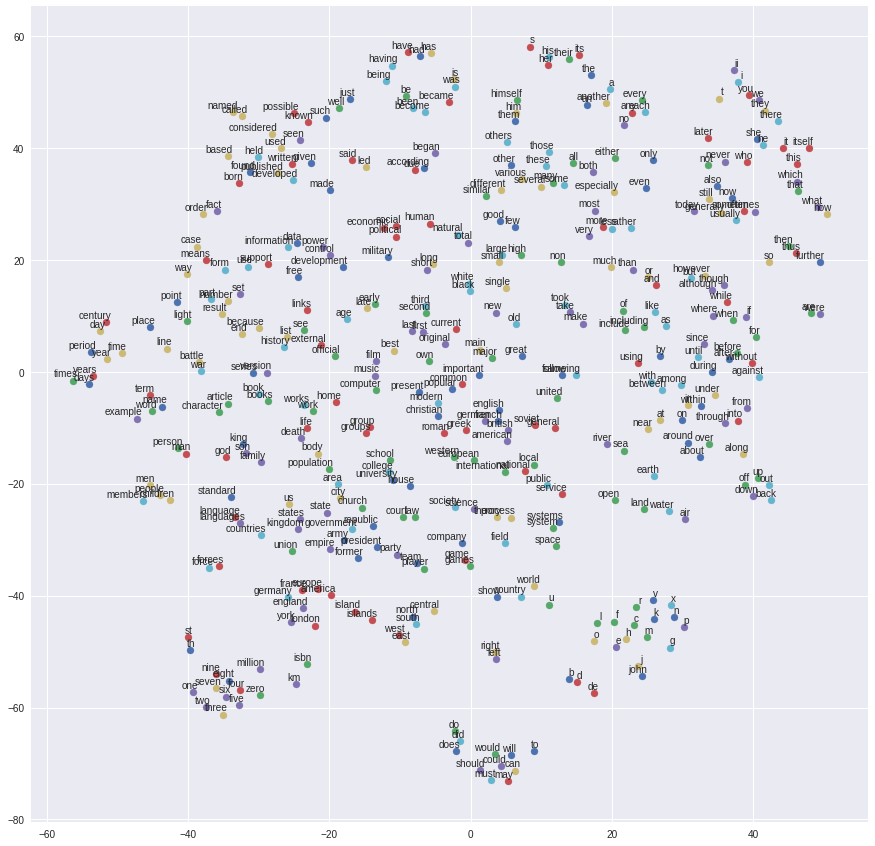

In [17]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

# Get the text for each word and plot each word
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Generate a training batch for the CBOW model.

In [0]:
# Index into where we are in the corpus data to create batches
# Is a global value (which is preserved from one batch to the next)
data_index = 0

#
# Generate one batch of training samples. 
# Each training sample is (centre_word, expected_context_word)
# Note that both centre_word and expected_context_word are the index of that word
# in the dictionary
# ------------------
# batch_size is the number of words to be included in the generated batch
# skip_window is the size of the context window
# num_skips is how many words from the context window to include
def generate_batch_cbow (batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  
  # create arrays for the data words and labels in a batch
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  # Span width includes the centre word + skip_window words before and after
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  # Create buffer as an empty double-ended queue
  buffer = collections.deque(maxlen=span)
  
  # Add span words sequentially to the buffer
  for _ in range(span):
    # Add a word from the span to the deque
    buffer.append(data[data_index])
    
    # Increment the global data index, and wrap when we reach the end
    data_index = (data_index + 1) % len(data)
  
  # batch_size // num_skips gives the number of 'word sets' to include in the
  # batch. A 'word set' consists of one centre word and all its associated context
  # words. There should be num_skips such associated context words for each
  # centre word
  # Go through the loop creating one 'word set' in each iteration of the loop
  for i in range(batch_size // num_skips):
    # Pick the word in the centre of the buffer as your centre word
    target = skip_window  # target label at the center of the buffer
    
    # Keep the index of the centre word (within the buffer) because we want
    # to avoid picking up the centre word as a context word
    targets_to_avoid = [ skip_window ]
    
    # Now loop through picking up num_skips number of words from the buffer
    for j in range(num_skips):
      
      # Keep generating random numbers within the span length so we can pick
      # up one context word at random from the buffer. But make sure that
      # we avoid picking up the centre word or words already picked
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
        
      # Once we pick a word, add it to the avoid list so we don't pick it up
      # again
      targets_to_avoid.append(target)
      
      # Fill the centre word into the batch data
      batch[i * num_skips + j] = buffer[skip_window]
      
      # Fill the context word into the label
      labels[i * num_skips + j, 0] = buffer[target]

    # Now slide the buffer by one position 
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

# Generate batches with different combinations of (num_skips, skip_window)
# skip_window = 1 and num_skips = 2 means take one word each before and after 
# the centre word, for a total of 2 words
# skip_window = 2 and num_skips = 4 means take two words each before and after 
# the centre word, for a total of 4 words
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])